In [1]:
import os
import sys
import tqdm
import keras
from keras import models, layers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.utils import plot_model
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from skimage.color import rgb2gray, rgb2lab,lab2rgb
from skimage.io import imsave
from keras.callbacks import TensorBoard,EarlyStopping,TerminateOnNaN,ReduceLROnPlateau,ModelCheckpoint

# 加载数据
from PIL import Image
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
inputcolor = "E:\\Chii\\百度云\\GitHub\\DeepLearning\\PictureColoring\\photo\\color\\"
inputbw = "E:\\Chii\\百度云\\GitHub\\DeepLearning\\PictureColoring\\photo\\black&white\\"
outputfile = "E:\\Chii\\百度云\\GitHub\\DeepLearning\\PictureColoring\\photo\\netcolor\\"
batch_size=10

Using TensorFlow backend.


In [2]:
file_abspath = os.path.abspath(sys.argv[0])  # exe所在文件地址
location = os.path.dirname(file_abspath)  # exe所在文件夹目录地址

tbCallBack  = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
esCallBack=EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
tnonCallBack = TerminateOnNaN()
rpCallBack = ReduceLROnPlateau(monitor='val_acc', factor=0.2,patience=3, min_lr=0.0001)
mcCallBack = ModelCheckpoint(filepath=file_abspath[:-3]+'.model', monitor='val_acc', mode='auto', period=1,save_best_only=True)

callbacklist=[tbCallBack,esCallBack,tnonCallBack,rpCallBack,mcCallBack]


In [3]:
def get_session(gpu_fraction=0.7):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session())

In [4]:
def load_data():
    imgs = os.listdir(inputcolor)
    # num = len(imgs)
    num = 100
    data = np.empty((num, 256, 256,1), dtype=float)
    label = np.empty((num, 256, 256, 2), dtype=float)
    for i in tqdm.trange(0, num, desc='Task', ncols=100):
        # Img = Image.open(inputcolor + imgs[i])
        Img = img_to_array(load_img(inputcolor + imgs[i]))
        Img = np.array(Img, dtype=float)
        Img = rgb2lab(1.0 / 255 * Img)

        greyImg = Img[:, :,0]
        greyImg = greyImg.reshape(256, 256, 1)

        colorImg = Img[:, :, 1:]/128
        colorImg = colorImg.reshape(256, 256, 2)

        data[i] = greyImg
        label[i] = colorImg

    return data, label


In [5]:

def build_model():
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(None, None, 1)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.compile(optimizer='rmsprop', loss='mse')
    return model



In [6]:
data, label = load_data()
print(data.shape[0])
slite= int(data.shape[0]*0.9)
train_data = data[:slite]
train_labels = label[:slite]
test_data = data[slite:]
test_labels = label[slite:]

Task:   0%|                                                                 | 0/100 [00:00<?, ?it/s]

Task:   3%|█▋                                                       | 3/100 [00:00<00:04, 23.63it/s]

Task:   6%|███▍                                                     | 6/100 [00:00<00:03, 24.21it/s]

Task:   8%|████▌                                                    | 8/100 [00:00<00:04, 22.54it/s]

Task:  11%|██████▏                                                 | 11/100 [00:00<00:04, 22.01it/s]

Task:  13%|███████▎                                                | 13/100 [00:00<00:04, 19.67it/s]

Task:  16%|████████▉                                               | 16/100 [00:00<00:04, 20.54it/s]

Task:  19%|██████████▋                                             | 19/100 [00:00<00:03, 21.02it/s]

Task:  21%|███████████▊                                            | 21/100 [00:00<00:03, 19.79it/s]

Task:  24%|█████████████▍                                          | 24/100 [00:01<00:03, 21.20it/s]

Task:  27%|███████████████                                         | 27/100 [00:01<00:03, 21.41it/s]

Task:  30%|████████████████▊                                       | 30/100 [00:01<00:03, 22.48it/s]

Task:  33%|██████████████████▍                                     | 33/100 [00:01<00:02, 23.68it/s]

Task:  36%|████████████████████▏                                   | 36/100 [00:01<00:02, 23.22it/s]

Task:  39%|█████████████████████▊                                  | 39/100 [00:01<00:02, 23.68it/s]

Task:  42%|███████████████████████▌                                | 42/100 [00:01<00:02, 24.36it/s]

Task:  45%|█████████████████████████▏                              | 45/100 [00:01<00:02, 25.04it/s]

Task:  48%|██████████████████████████▉                             | 48/100 [00:02<00:02, 25.03it/s]

Task:  51%|████████████████████████████▌                           | 51/100 [00:02<00:01, 25.09it/s]

Task:  54%|██████████████████████████████▏                         | 54/100 [00:02<00:01, 25.39it/s]

Task:  57%|███████████████████████████████▉                        | 57/100 [00:02<00:01, 26.13it/s]

Task:  60%|█████████████████████████████████▌                      | 60/100 [00:02<00:01, 26.12it/s]

Task:  63%|███████████████████████████████████▎                    | 63/100 [00:02<00:01, 26.53it/s]

Task:  66%|████████████████████████████████████▉                   | 66/100 [00:02<00:01, 25.79it/s]

Task:  69%|██████████████████████████████████████▋                 | 69/100 [00:02<00:01, 26.29it/s]

Task:  72%|████████████████████████████████████████▎               | 72/100 [00:02<00:01, 26.37it/s]

Task:  75%|██████████████████████████████████████████              | 75/100 [00:03<00:00, 26.64it/s]

Task:  78%|███████████████████████████████████████████▋            | 78/100 [00:03<00:00, 26.13it/s]

Task:  81%|█████████████████████████████████████████████▎          | 81/100 [00:03<00:00, 25.52it/s]

Task:  84%|███████████████████████████████████████████████         | 84/100 [00:03<00:00, 25.37it/s]

Task:  87%|████████████████████████████████████████████████▋       | 87/100 [00:03<00:00, 25.45it/s]

Task:  90%|██████████████████████████████████████████████████▍     | 90/100 [00:03<00:00, 26.25it/s]

Task:  93%|████████████████████████████████████████████████████    | 93/100 [00:03<00:00, 25.87it/s]

Task:  96%|█████████████████████████████████████████████████████▊  | 96/100 [00:03<00:00, 25.87it/s]

Task:  99%|███████████████████████████████████████████████████████▍| 99/100 [00:04<00:00, 26.28it/s]

Task: 100%|███████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.54it/s]

100

In [11]:
model = build_model()
def data_generator(data, targets, batch_size):
    batches = (len(data) + batch_size - 1) // batch_size
    while (True):
        for i in range(batches):
            X = data[i * batch_size: (i + 1) * batch_size]
            Y = targets[i * batch_size: (i + 1) * batch_size]
            yield (X, Y)

history = model.fit_generator(generator=data_generator(train_data, train_labels, batch_size),
                              validation_data=(test_data, test_labels),
                              epochs=200,
                              steps_per_epoch=10,
                              callbacks=callbacklist
                              )

Epoch 1/200

 1/10 [==>...........................]

 - ETA: 4s - loss: 0.0058



 2/10 [=====>........................]

 - ETA: 2s - loss: 0.4561



 3/10 [========>.....................]

 - ETA: 1s - loss: 0.6296



 4/10 [===========>..................]

 - ETA: 1s - loss: 0.4744



 5/10 [==============>...............]

 - ETA: 1s - loss: 0.3839



 6/10 [=================>............]

 - ETA: 0s - loss: 0.3229



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.2777



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.2838



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.2539



10/10 [==============================]

 - 2s 184ms/step - loss: 0.2290 - val_loss: 0.0169


Epoch 2/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0089



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0151



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0130



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0120



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0109



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0100



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0098



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0113



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0105



10/10 [==============================]

 - 1s 142ms/step - loss: 0.0103 - val_loss: 0.0157


Epoch 3/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0171



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0126



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0112



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0098



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0089



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0088



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0091



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0100



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0098



10/10 [==============================]

 - 1s 144ms/step - loss: 0.0105 - val_loss: 0.0154


Epoch 4/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0081



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0083



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0074



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0068



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0071



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0079



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0075



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0075



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0084



10/10 [==============================]

 - 1s 142ms/step - loss: 0.0084 - val_loss: 0.0150


Epoch 5/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0086



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0070



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0062



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0065



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0075



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0073



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0072



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0083



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 1s 142ms/step - loss: 0.0083 - val_loss: 0.0148


Epoch 6/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0053



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0050



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0058



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0071



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0070



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0070



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0082



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0083



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 1s 146ms/step - loss: 0.0080 - val_loss: 0.0148


Epoch 7/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0047



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0060



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0076



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0074



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0073



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0087



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0087



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0087



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 1s 143ms/step - loss: 0.0079 - val_loss: 0.0149


Epoch 8/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0073



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0091



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0083



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0080



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0095



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0094



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0092



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0088



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 1s 144ms/step - loss: 0.0082 - val_loss: 0.0151


Epoch 9/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0110



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0088



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0082



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0102



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0105



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0102



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0096



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0279



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0257



10/10 [==============================]

 - 1s 144ms/step - loss: 0.0243 - val_loss: 0.0151


Epoch 10/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0060



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0065



 3/10 [========>.....................]

 - ETA: 1s - loss: 0.0096



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0093



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0092



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0086



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0080



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0079



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 1s 150ms/step - loss: 0.0081 - val_loss: 0.0149


Epoch 11/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0070



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0113



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0104



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0099



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0090



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0083



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0082



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0085



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 1s 142ms/step - loss: 0.0082 - val_loss: 0.0149


Epoch 12/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0157



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0121



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0109



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0095



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0086



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0084



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0087



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0085



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 1s 141ms/step - loss: 0.0090 - val_loss: 0.0149


Epoch 13/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0085



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0086



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0075



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0068



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0069



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0076



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0074



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0074



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 2s 151ms/step - loss: 0.0083 - val_loss: 0.0148


Epoch 14/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0086



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0070



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0062



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0065



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0074



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0072



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0072



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0083



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 2s 151ms/step - loss: 0.0083 - val_loss: 0.0148


Epoch 15/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0053



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0050



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0058



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0071



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0070



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0070



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0082



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0082



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 1s 143ms/step - loss: 0.0080 - val_loss: 0.0148


Epoch 16/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0047



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0060



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0076



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0074



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0073



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0087



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0087



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0087



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 1s 144ms/step - loss: 0.0079 - val_loss: 0.0149


Epoch 17/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0071



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0090



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0077



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0075



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0090



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0093



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0092



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0087



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0084



10/10 [==============================]

 - 1s 149ms/step - loss: 0.0082 - val_loss: 0.0151


Epoch 18/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0109



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0089



 3/10 [========>.....................]

 - ETA: 1s - loss: 0.0083



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0101



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0098



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0096



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0090



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0085



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 1s 148ms/step - loss: 0.0086 - val_loss: 0.0149


Epoch 19/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0066



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0068



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0097



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0094



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0093



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0086



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0080



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0079



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 1s 148ms/step - loss: 0.0081 - val_loss: 0.0148


Epoch 20/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0069



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0113



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0104



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0099



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0090



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0083



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0081



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0085



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 2s 151ms/step - loss: 0.0081 - val_loss: 0.0149


Epoch 21/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0156



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0121



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0109



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0095



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0086



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0083



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0087



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0084



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 1s 148ms/step - loss: 0.0090 - val_loss: 0.0149


Epoch 22/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0085



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0086



 3/10 [========>.....................]

 - ETA: 1s - loss: 0.0075



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0068



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0069



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0076



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0074



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0074



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 1s 149ms/step - loss: 0.0083 - val_loss: 0.0148


Epoch 23/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0087



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0070



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0062



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0065



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0074



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0072



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0072



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0082



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0082



10/10 [==============================]

 - 2s 151ms/step - loss: 0.0149 - val_loss: 0.0160


Epoch 24/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0059



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0052



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0105



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0106



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0098



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0093



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0102



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0100



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0098



10/10 [==============================]

 - 1s 147ms/step - loss: 0.0094 - val_loss: 0.0148


Epoch 25/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0047



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0060



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0076



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0073



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0073



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0086



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0086



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0086



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0083



10/10 [==============================]

 - 1s 149ms/step - loss: 0.0079 - val_loss: 0.0157


Epoch 26/200

 1/10 [==>...........................]

 - ETA: 1s - loss: 0.0104



 2/10 [=====>........................]

 - ETA: 1s - loss: 0.0107



 3/10 [========>.....................]

 - ETA: 0s - loss: 0.0092



 4/10 [===========>..................]

 - ETA: 0s - loss: 0.0087



 5/10 [==============>...............]

 - ETA: 0s - loss: 0.0101



 6/10 [=================>............]

 - ETA: 0s - loss: 0.0098



 7/10 [====================>.........]

 - ETA: 0s - loss: 0.0096



 8/10 [=======================>......]

 - ETA: 0s - loss: 0.0091



 9/10 [==========================>...]

 - ETA: 0s - loss: 0.0086

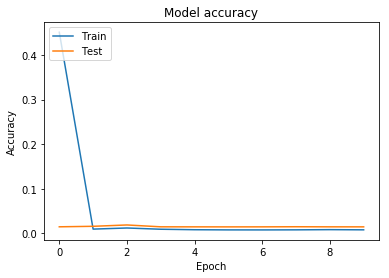

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
model.evaluate(train_data, train_labels)
output = model.predict(train_data)
output *= 128
# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:, :, 0] = train_data[i][:, :, 0]
    cur[:, :, 1:] = output[i]
    imsave(outputfile+str(i)+'.jpg', lab2rgb(cur))

32/90 [=========>....................]

 - ETA: 3s



64/90 [====================>.........]

 - ETA: 0s



90/90 [==============================]

 - 4s 42ms/step


D:\Software\Anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
